## Making Facial Images Smile with VAE

Autoencoder enables us to generate a completely new sample with use of the decoder part. Another one is our hope for it to capture more meaningful latent variables after all. As the diagonal covariance matrix prior on z implies **independent latent variables**, different dimensions of z
will hopefully encode distinct interpretable factors of variation. A very famous example of this phenomenon is the following photo:

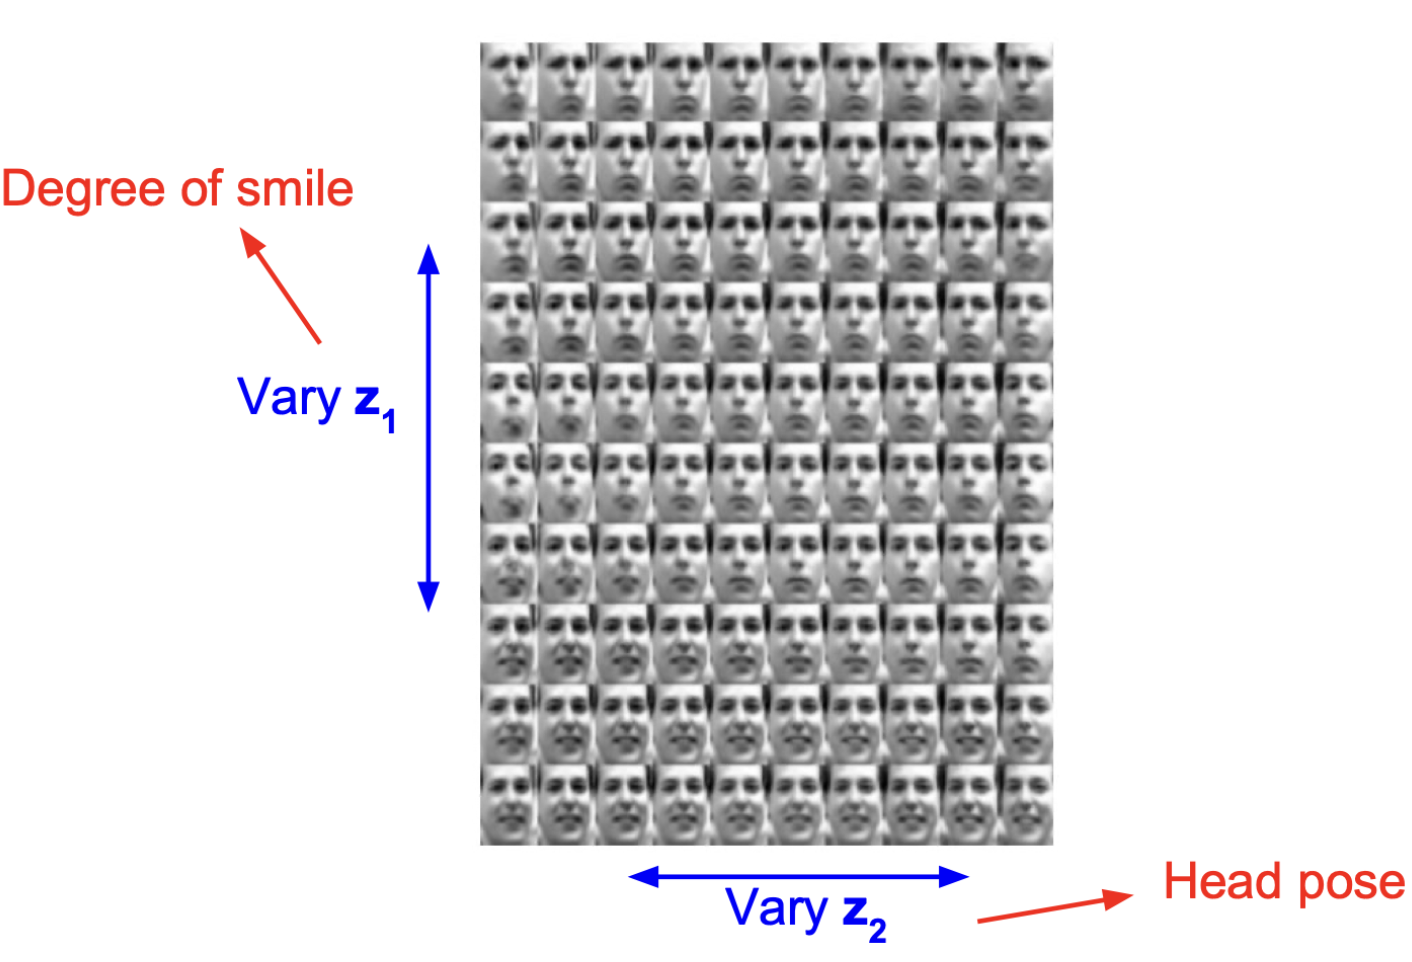

CelebFaces Attributes Dataset (CelebA) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter. CelebA has large diversities, together with tagged attributes such as 'Smiling', 'Wearing glasses', or 'Wearing lipstick'. Having said that, it's a great candidate with many specific features of image that we'll try to retrieve some of them in the latent space.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from tqdm.notebook import tqdm

dtype = torch.float32
device = 'cuda:0'

#### Loading the dataset

In [2]:
import os
import zipfile
import gdown
from natsort import natsorted
from PIL import Image

# Root directory for the dataset
data_root = 'data'
# Path to folder with the dataset
dataset_folder = f'{data_root}/img_align_celeba'
# URL for the CelebA dataset
url = 'https://drive.google.com/u/3/uc?id=1AKHD6n6vfkin9D6xnRylXHBs7RjbMid5'
# Path to download the dataset to
download_path = f'{data_root}/img_align_celeba.zip'

# Create required directories
if not os.path.exists(data_root):
    os.makedirs(data_root)
    os.makedirs(dataset_folder)

In [3]:
# Download the dataset from google drive
gdown.download(url, download_path, quiet=False)

with zipfile.ZipFile(download_path, 'r') as ziphandler:
    ziphandler.extractall(dataset_folder)

Downloading...
From (original): https://drive.google.com/u/3/uc?id=1AKHD6n6vfkin9D6xnRylXHBs7RjbMid5
From (redirected): https://drive.google.com/uc?id=1AKHD6n6vfkin9D6xnRylXHBs7RjbMid5&confirm=t&uuid=5b621f9d-6923-4130-bd79-e8d94a1b99ce
To: /content/data/img_align_celeba.zip
100%|██████████| 1.50G/1.50G [00:23<00:00, 63.4MB/s]


#### Data Preprocessing and Build celeba_dataloader

In [4]:
# Create a custom Dataset class
class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
        root_dir (string): Directory with all the images
        transform (callable, optional): transform to be applied to each image sample
        """
        # Read names of images in the root directory
        image_names = os.listdir(root_dir)

        self.root_dir = root_dir
        self.transform = transform
        self.image_names = natsorted(image_names)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        # Get the path to the image
        img_path = os.path.join(self.root_dir, self.image_names[idx])
        # Load image and convert it to RGB
        img = Image.open(img_path).convert('RGB')
        # Apply transformations to the image
        if self.transform:
            img = self.transform(img)

        return img

# Path to directory with all the images
img_folder = f'{dataset_folder}/img_align_celeba'

# Spatial size of training images, images are resized to this size.
image_size = 64

transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
])

# Load the dataset from file and apply transformations
celeba_dataset = CelebADataset(img_folder, transform)

batch_size = 32
celeba_dataloader = torch.utils.data.DataLoader(celeba_dataset,
                                                batch_size=batch_size,
                                                pin_memory= True,
                                                shuffle=True)

Let's load a batch of data and plot the images to see how these look after all:

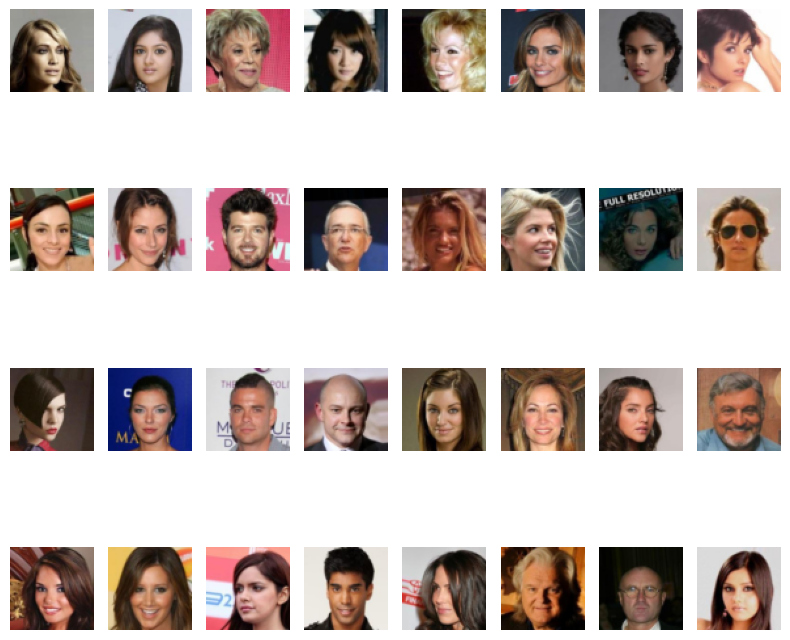

In [5]:
X = next(iter(celeba_dataloader))

# Use the above batch(32images) to subplot all of images inside it next to each other.

figure = plt.figure(figsize=(8, 8))
cols, rows = 8, 4
# Iterate over each image in the batch
for i in range(batch_size):
    img = X[i]
    # move the channel dimension to the end
    img = img.permute(1, 2, 0)
    ax = figure.add_subplot(rows, cols, i+1)
    ax.axis("off")
    plt.imshow(img)

plt.tight_layout()
plt.show()

#### Encoder

Encoder is composed from two parts. A network that outputs $\mu_{z|x}$ and $\Sigma_{z|x}$, and a sampler that generates multi-dimensional guassian distribution according those mean vector and covariance matrix. The network we will use is inspired by the [original paper](https://arxiv.org/abs/1312.6114) that brought this first:
* Conv2D: 32 Filters, 4x4, Stride 2, padding 1
* ReLU
* Batch Normalization
* Conv2D: 64 Filters, 4x4, Stride 2, padding 1
* ReLU
* Batch Normalization
* Conv2D: 128 Filters, 4x4, Stride 2, padding 1
* ReLU
* Batch Normalization
* Conv2D: 256 Filters, 4x4, Stride 2, padding 1
* ReLU
* Batch Normalization
* Flatten
* Fully Connected of output size "latent_dim" for mu
* Fully Connected of output size "latent_dim" for logarithms of variances
* Sampler to genrerate z



In [6]:
def conv_block(in_ch, out_ch, kernel, stride, pad):
    model = nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size = kernel, stride = stride, padding = pad),
        nn.ReLU(),
        nn.BatchNorm2d(out_ch)
    )
    return model

def sampler(mu, log_var):
    """
    Generates multi-dimensional gaussian RV

    Inputs:
    - mu: PyTorch Variable of shape (-1, latent_size) for the mean of distribution.
    - log_var: PyTorch Variable of shape (-1, latent_size) for the variance logarithms of distribution.

    Returns:
    - z: PyTorch Variable of shape (-1 latent_size) that comes from the according distribution.
    """
    # standard deviation
    std = torch.exp(0.5*log_var)
    # random noise with the same shape as mu and log_var
    eps = torch.randn_like(std)
    z = mu + eps*std

    return z


class encoder(nn.Module):
    def __init__(self, latent_dim = 512):
        super().__init__()

        self.conv1 = conv_block(3, 32, 4, 2, 1)
        self.conv2 = conv_block(32, 64, 4, 2, 1)
        self.conv3 = conv_block(64, 128, 4, 2, 1)
        self.conv4 = conv_block(128, 256, 4, 2, 1)
        # Initialize the fully connected layer to output mu and log_var
        self.fc_mu = nn.Linear(256*4*4, latent_dim)
        self.fc_log_var = nn.Linear(256*4*4, latent_dim)
        self.KL = 0

    def forward(self, x):
        # Put all parts together to get a generated z as output.
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # flatten
        x = x.view(x.size(0), -1)
        # mu and log_var
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        # KL divergence
        self.KL = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        z = sampler(mu, log_var)
        return z

#### Decoder

For the decoder we will use a network simiar to the [original paper](https://arxiv.org/abs/1312.6114) as well.

* Fully connected from latent-dim to 4096.
* ReLU
* Batch Normalization
* Unflatten: Reshaping to (-1, 256, 4, 4)
* ConvTranspose2d: 128 Filters, 4x4, Stride 2, padding 1
* ReLU
* Batch Normalization
* ConvTranspose2d: 64 Filters, 4x4, Stride 2, padding 1
* ReLU
* Batch Normalization
* ConvTranspose2d: 32 Filters, 4x4, Stride 2, padding 1
* ReLU
* Batch Normalization
* ConvTranspose2d: 3 Filters, 4x4, Stride 2, padding 1
* Sigmoid to get values betwenn 0 and 1 for the output image

In [7]:
def convT_block(in_ch, out_ch, kernel, stride, pad, batch = False):
    model = nn.Sequential(
        nn.ConvTranspose2d(in_ch, out_ch, kernel_size = kernel, stride = stride, padding = pad),
        nn.ReLU(),
        nn.BatchNorm2d(out_ch)
    )
    return model

class decoder(nn.Module):
    def __init__(self, latent_dim = 512):
        super().__init__()

        # Initialize the fully connected layer
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 4096),
            nn.ReLU(),
            nn.BatchNorm1d(4096)
        )
        # Initialize the deconvolution block
        self.convT1 = convT_block(256, 128, 4, 2, 1)
        self.convT2 = convT_block(128, 64, 4, 2, 1)
        self.convT3 = convT_block(64, 32, 4, 2, 1)
        self.convT4 = convT_block(32, 3, 4, 2, 1)

    def forward(self, x):
        # Put all parts together to get a an image as output.
        # Pass input through fully connected layer
        x = self.fc(x)
        # Reshape to fit deconvolution block
        x = x.view(x.size(0), 256, 4, 4)
        # Passing the input through the deconvolution block
        x = self.convT1(x)
        x = self.convT2(x)
        x = self.convT3(x)
        x = self.convT4(x)
        # apply sigmoid activation function to get final image
        output = torch.sigmoid(x)

        return output

#### VAE

The following cell connects encoder and decoder to form the end-to-end architecture.

In [8]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        # Call instances for both encoder and decoder.
        self.encoder = encoder(latent_dim)
        self.decoder = decoder(latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        output = self.decoder(z)

        return output

#### Loss function and Training

For the loss term let's now define the reconstruction loss that in addition to KL divergence that gets saved in encoder at everyrun, they make the whole loss function. This function should take a batch of images of shape (batch_size, 3, 64, 64) in the first argument, and the output after passing the batch of images through VAE in the second argument. For the reconstruction loss use [binary cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) loss with reduction set to 'sum'.  

In [9]:
def loss_fn(recon_batch, batch):
    """
    outputs reconstruction loss

    Inputs:
    - recon_batch: PyTorch tensor of shape (-1, 3, 64, 64) means to be the reconstructed image.
    - batch: Pytorch tesnor of shape (-1, 3, 64, 64) that is the input at every iteration.

    Returns:
    - loss: PyTorch scalar.
    """

    # flatten the reconstructed batch and the original batch
    recon_batch = recon_batch.view(recon_batch.shape[0], -1)
    batch = batch.view(batch.shape[0], -1)
    # compute binary cross entropy loss
    reconstruction_loss = torch.nn.functional.binary_cross_entropy(recon_batch, batch, reduction='sum')
    return reconstruction_loss

And traing the model in the end:

In [10]:
vae = VAE(512).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr = 5e-4)

def train(model, epochs, dataloader, opt, loss_fn):
    model.train()
    for epoch in tqdm(range(1, epochs+1)):
        train_loss = 0

        for batch_idx, data in enumerate(dataloader):
            data = data.to(device = device)
            recon_batch = model(data)
            loss = loss_fn(recon_batch.view(recon_batch.shape[0], -1), data.view(data.shape[0], -1)) + vae.encoder.KL

            loss.backward()
            opt.step()
            opt.zero_grad()

            train_loss += loss.item()

            if batch_idx % 1000 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(dataloader.dataset),
                    100. * batch_idx / len(dataloader), loss.item() / len(data)))
        print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(dataloader.dataset)))

In [11]:
train(vae, 10, celeba_dataloader, optimizer, loss_fn)

  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 1 [0/202599 (0%)]	Loss: 9897.034180
Train Epoch: 1 [32000/202599 (16%)]	Loss: 6590.375000
Train Epoch: 1 [64000/202599 (32%)]	Loss: 6242.556641
Train Epoch: 1 [96000/202599 (47%)]	Loss: 6445.269531
Train Epoch: 1 [128000/202599 (63%)]	Loss: 6526.785156
Train Epoch: 1 [160000/202599 (79%)]	Loss: 6639.582520
Train Epoch: 1 [192000/202599 (95%)]	Loss: 6696.708008
====> Epoch: 1 Average loss: 6597.3937
Train Epoch: 2 [0/202599 (0%)]	Loss: 6458.342773
Train Epoch: 2 [32000/202599 (16%)]	Loss: 6666.610840
Train Epoch: 2 [64000/202599 (32%)]	Loss: 6532.490234
Train Epoch: 2 [96000/202599 (47%)]	Loss: 6239.070312
Train Epoch: 2 [128000/202599 (63%)]	Loss: 6592.770020
Train Epoch: 2 [160000/202599 (79%)]	Loss: 6501.200684
Train Epoch: 2 [192000/202599 (95%)]	Loss: 6167.430664
====> Epoch: 2 Average loss: 6412.4177
Train Epoch: 3 [0/202599 (0%)]	Loss: 6299.637695
Train Epoch: 3 [32000/202599 (16%)]	Loss: 6495.884766
Train Epoch: 3 [64000/202599 (32%)]	Loss: 6055.173828
Train Epoch: 

#### Compute Reconstructions of test images

Now take a look at some image reconstructions from the encoder-decoder architecture. Using the end-to-end VAE model for just one batch to see how reconstructions are good or bad.

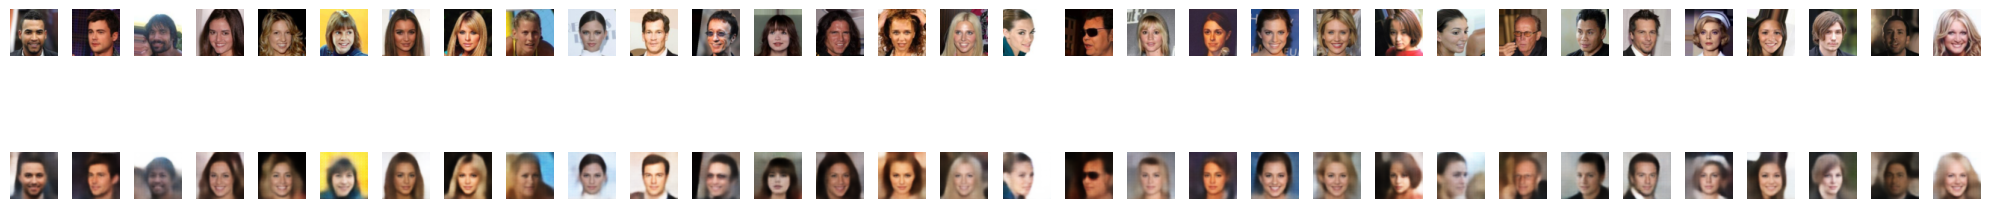

In [12]:
X = next(iter(celeba_dataloader))

# Use above batch to plot all of images inside one batch and their reconstructions
vae.eval()
recon_X = vae(X.to(device))  # reconstructed image
recon_X = recon_X.cpu().detach()  # Move the reconstructed image to the CPU and separate it from the computational graph

figure, axes = plt.subplots(nrows=2, ncols=batch_size, figsize=(20, 4))

# Iterate over each image in the batch
for i in range(batch_size):
    # original image and reconstructed image
    original_img = X[i].permute(1, 2, 0)
    recon_img = recon_X[i].permute(1, 2, 0)
    # Show original image in first row
    axes[0, i].imshow(original_img)
    axes[0, i].axis('off')
    # Display the reconstructed image in the second row
    axes[1, i].imshow(recon_img)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

#### Modify generations with attribute vector

Now let's see how the latent space encodes high-level information about the images, even though it has not been trained with any information apart from the images themselves.

As mentioned in the introduction, each image in the CelebA dataset is labelled according to the attributes of the person pictured. There is another list with the datasets that includes the feature information for every image in the dataset. If someone has a particular feature the value is 1, otherwise -1. Looking like this:

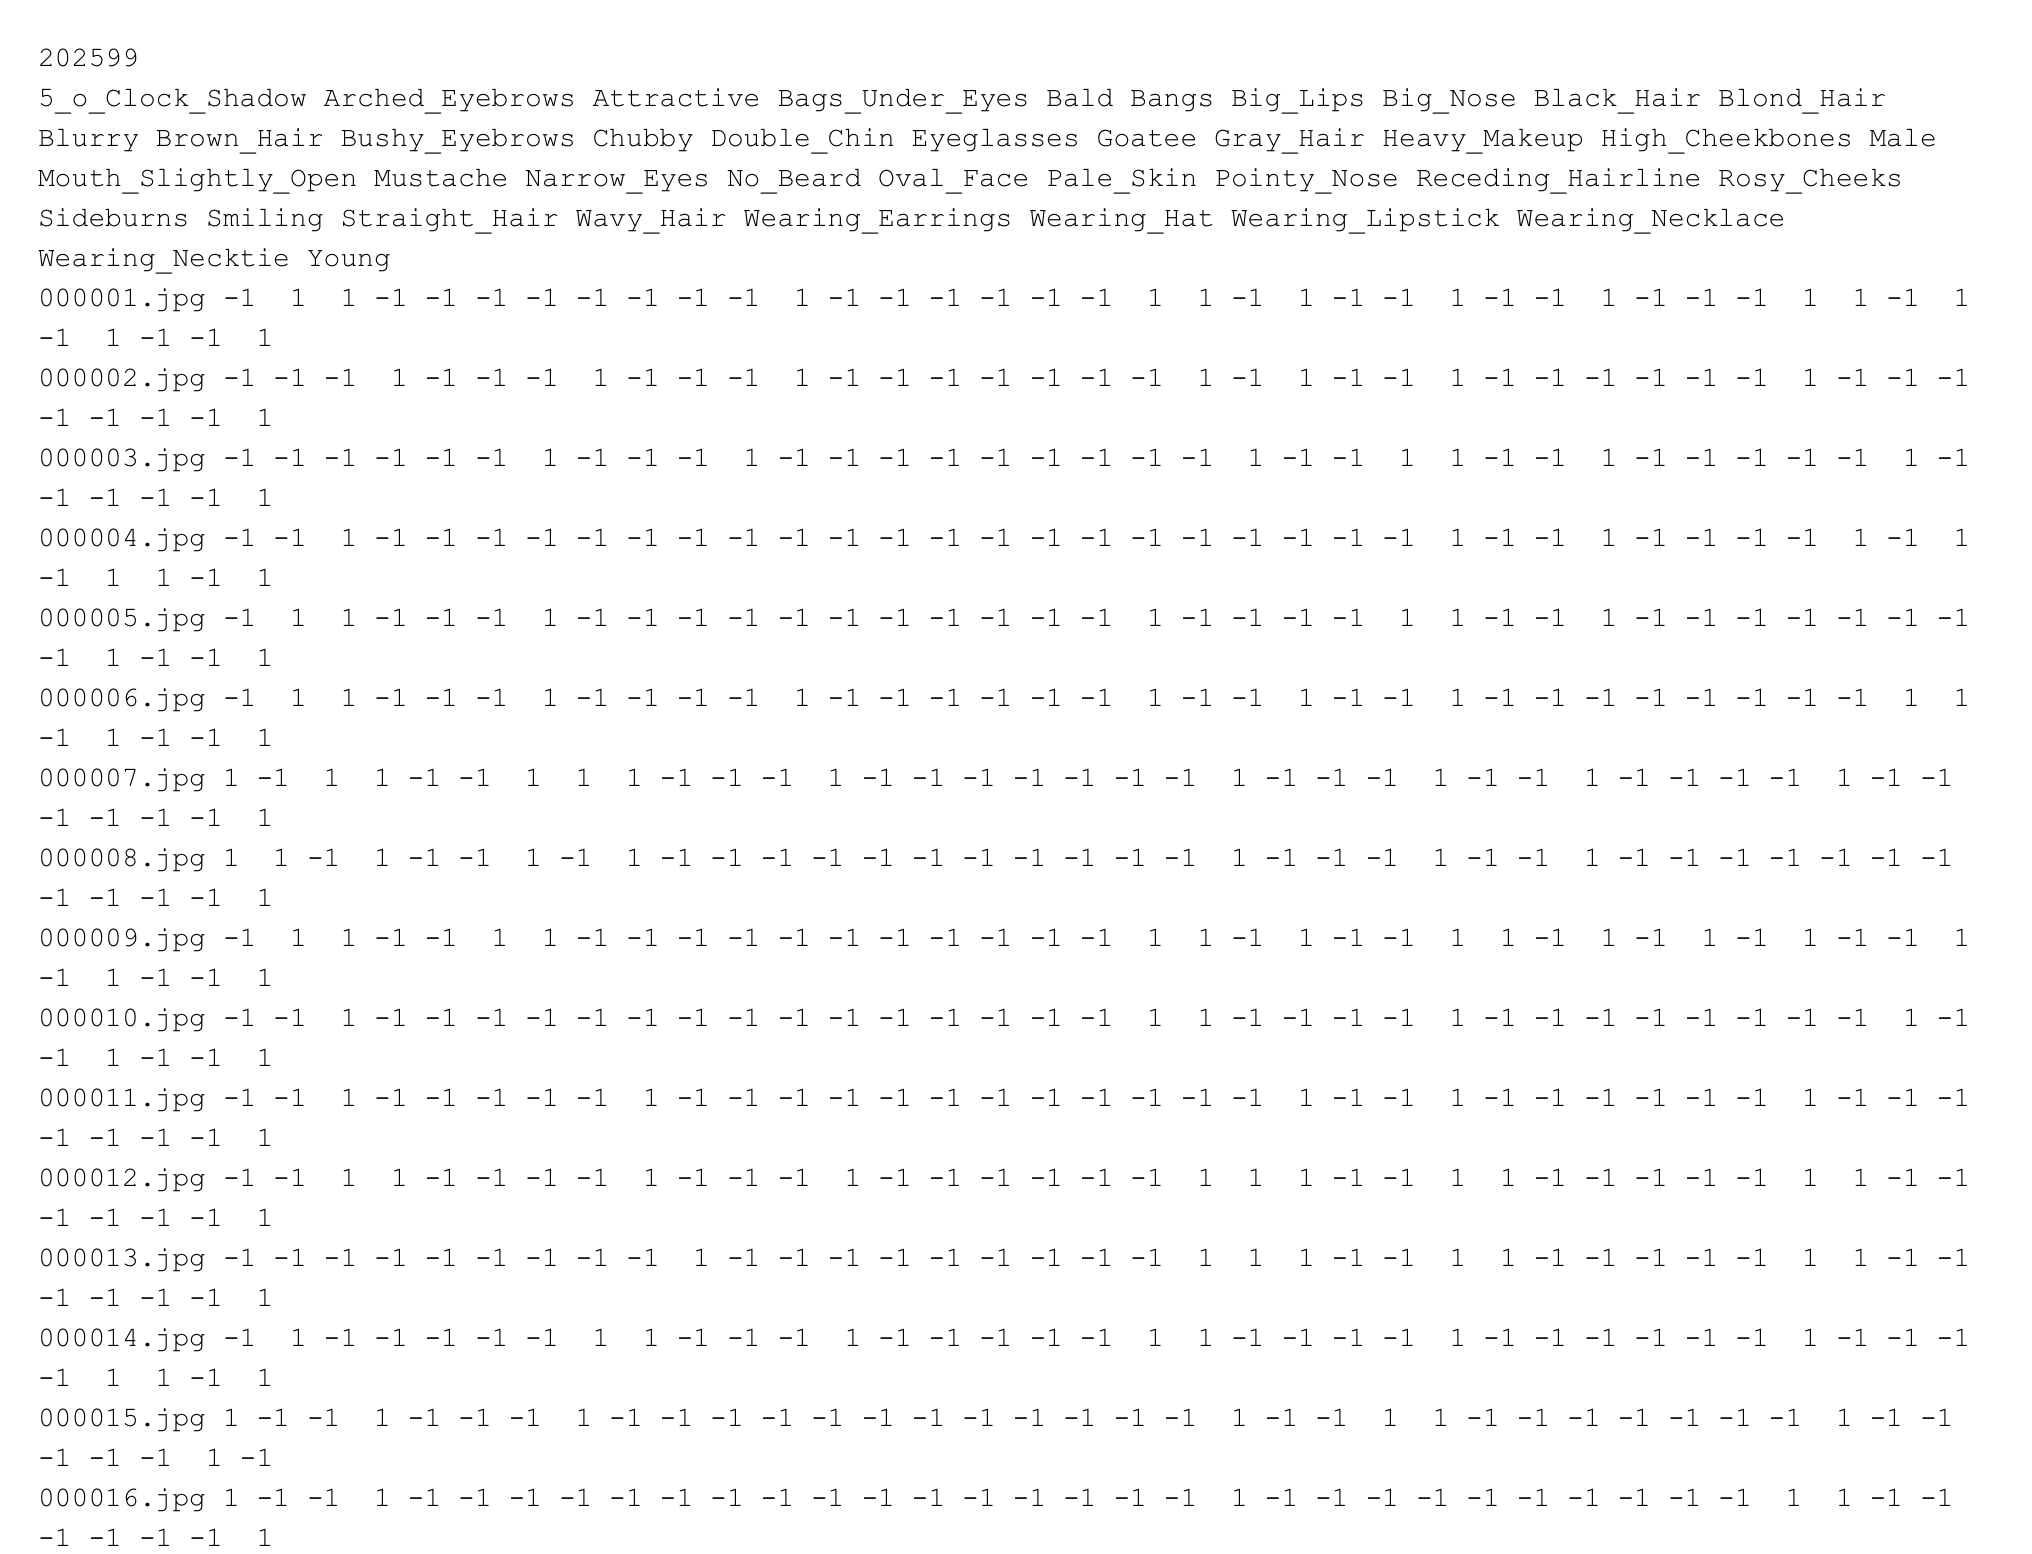

This cell extracts indices that correspond to the images with smile.

In [13]:
# URL for the list
url = 'https://drive.google.com/uc?id=1ULRnFex1F9tQlemhTneMTaLj_2tDRaIa'

download_path = f'{data_root}/list_attr_celeba.txt'

# Download the dataset from google drive
gdown.download(url, download_path, quiet=False)

def getlist(path, attributes, values):
    # path: string path of the file its gonna read
    # attributes: a list of attributions we want to consider, e.g. ['Male', Young']
    # values: Being positive or negatavie on those attributes, e.g. [1, 1]

    with open(path, 'r') as f:
        lines= f.read().splitlines()
        features= lines[1].split()
        atts= [[int(x) for x in line.split()[1:]] for line in lines[2:]]
        A= np.array(atts)

    indices= [features.index(x) for x in attributes if x in features]

    return np.where(np.all(A[:, indices]== values, axis= 1))[0]+1

idx= getlist(download_path, ['Smiling'], [1])
not_idx = getlist(download_path, ['Smiling'], [-1])

Downloading...
From: https://drive.google.com/uc?id=1ULRnFex1F9tQlemhTneMTaLj_2tDRaIa
To: /content/data/list_attr_celeba.txt
100%|██████████| 26.7M/26.7M [00:00<00:00, 37.3MB/s]


In [14]:
print(idx.shape)

(97669,)


In [15]:
# fix index
dataset_size = len(celeba_dataset)
not_idx = [i - 1 for i in not_idx if i <= dataset_size]

Now encode each of the images that have the chosen attribute into the latent space by passing them through the encoder. Then average the latent codes obtained for all of these images to obtain a single latent code.

Then do the same for the images that do not have the chosen attribute. This gives an average latent code for images with the attribute, and an average latent code for images without the attribute. Intuitively speaking, the difference between these two vectors then gives the 'direction' in latent space that corresponds to the presence of the attribute.

In [16]:
# Create a new dataset using the provided index
smiling_dataset = torch.utils.data.Subset(celeba_dataset, idx)
not_smiling_dataset = torch.utils.data.Subset(celeba_dataset, not_idx)

# Create dataloader
smiling_dataloader = torch.utils.data.DataLoader(smiling_dataset, batch_size=batch_size, shuffle=True)
not_smiling_dataloader = torch.utils.data.DataLoader(not_smiling_dataset, batch_size=batch_size, shuffle=True)

In [17]:
# Loop over two new dataloaders to get the mean vectors for each of them
latent_dim = 512
vae.eval()

with torch.no_grad():
    # Get the average latent code for a smiling image
    mean_encoded_images_with_attribute = torch.zeros(latent_dim).to(device)
    for data in smiling_dataloader:
        data = data.to(device)
        z = vae.encoder(data)
        mean_encoded_images_with_attribute += z.mean(dim=0)
    mean_encoded_images_with_attribute /= len(smiling_dataloader)

    # Get the average latent code for not smiling images
    mean_encoded_images_without_attribute = torch.zeros(latent_dim).to(device)
    for data in not_smiling_dataloader:
        data = data.to(device)
        z = vae.encoder(data)
        mean_encoded_images_without_attribute += z.mean(dim=0)
    mean_encoded_images_without_attribute /= len(not_smiling_dataloader)

attribute_vector = mean_encoded_images_with_attribute - mean_encoded_images_without_attribute

Now pass this vector to the decoder to see how a smiling person looks like

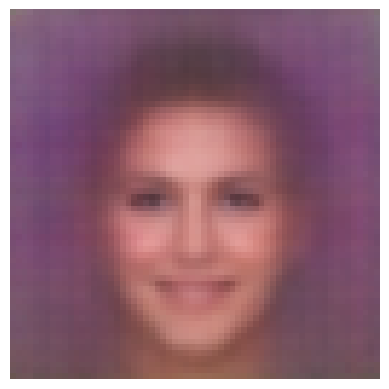

In [18]:
with torch.no_grad():
    # Pass the attribute vector to the decoder to generate the image
    attribute_image = vae.decoder(attribute_vector.unsqueeze(0))
    # Move the image to the CPU and detach it from the computation graph
    attribute_image = attribute_image.cpu().detach().squeeze().permute(1, 2, 0)
    plt.imshow(attribute_image)
    plt.axis('off')
    plt.show()

We can now use the attribute vector to add the attribute to an image reconstruction, where that attribute wasn't present before. To do this, just add the attribute vector to the latent vector encoding of the image, and then decode the result. We can also adjust the strength of the attribute vector by scaling with a multiplicative parameter.

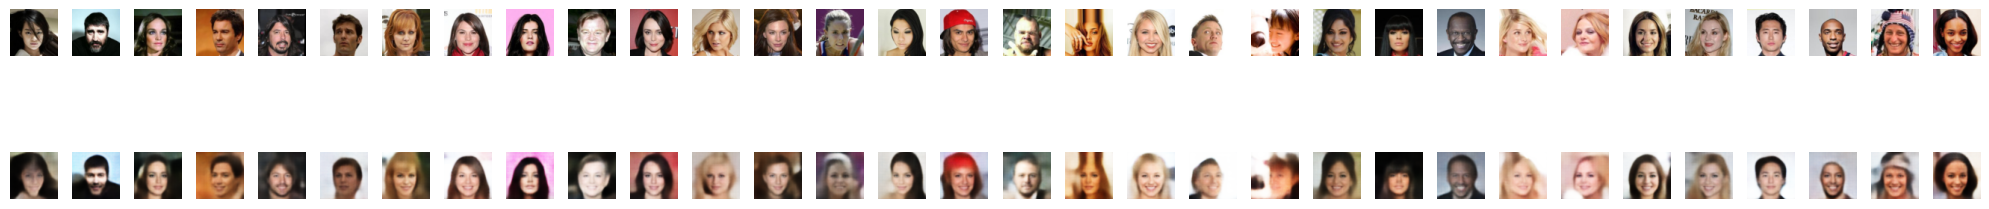

In [19]:
# Use one batch of the initial dataloader and make them smile
X = next(iter(celeba_dataloader))  # Get a batch of images
X = X.to(device)

with torch.no_grad():
    z = vae.encoder(X)
    # Add attribute vector to make image smile
    z_smiling = z + attribute_vector.unsqueeze(0)
    # Decode the modified latent code to get the smile image
    X_smiling = vae.decoder(z_smiling)
    X_smiling = X_smiling.cpu().detach()

# Show original image and smile image
figure, axes = plt.subplots(nrows=2, ncols=batch_size, figsize=(20, 4))
for i in range(batch_size):
    original_img = X[i].cpu().permute(1, 2, 0)
    smiling_img = X_smiling[i].permute(1, 2, 0)
    axes[0, i].imshow(original_img)
    axes[0, i].axis('off')
    axes[1, i].imshow(smiling_img)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

Note that most of the generated faces look more like female faces. This may because of the dataset bias(there are more female faces than male faces in the CelebA dataset). This bias affects model training because models typically have better reconstruction and generation capabilities for features they see more frequently in the training data. Therefore, if an attribute (such as gender) is unbalanced in the dataset, the model's performance may be biased towards the majority class.
